# ChronoTick 2: Data Exploration

This notebook explores the sensor data collected for clock drift prediction.
It demonstrates the preprocessing pipeline, sensor categories, and target
variable (adj_freq_ppm) characteristics across all four machines.

## Setup

**Local:** Run from `tick2/` directory with `uv run jupyter lab`.

**Colab:** Upload `data/24h_snapshot/` to Google Drive under `My Drive/chronotick2/data/`,
then run the setup cell below. The tick2 package is installed from GitHub automatically.

In [ ]:
# === Colab Setup (skip if running locally) ===
import os
import subprocess
import sys

IN_COLAB = "COLAB_GPU" in os.environ or os.path.exists("/content")

if IN_COLAB:
    REPO_DIR = "/content/sensor-collector"
    REPO_URL = "https://github.com/JaimeCernuda/sensor-collector.git"

    # Read GitHub token from Colab secrets (set via sidebar key icon).
    # Required for git push; without it the notebook runs but cannot push.
    GITHUB_TOKEN = None
    try:
        from google.colab import userdata
        GITHUB_TOKEN = userdata.get("GITHUB_TOKEN")
    except (ImportError, userdata.SecretNotFoundError):
        print("WARNING: GITHUB_TOKEN secret not set. Git push will be skipped.")
        print("  To enable: Colab sidebar > Secrets > Add GITHUB_TOKEN")

    # Build authenticated URL if token available
    if GITHUB_TOKEN:
        auth_url = f"https://{GITHUB_TOKEN}@github.com/JaimeCernuda/sensor-collector.git"
    else:
        auth_url = REPO_URL

    # Clone or pull latest
    if os.path.exists(REPO_DIR):
        # Update remote URL in case token was added after initial clone
        subprocess.run(["git", "-C", REPO_DIR, "remote", "set-url", "origin", auth_url], check=True)
        subprocess.run(["git", "-C", REPO_DIR, "pull", "-q"], check=True)
    else:
        subprocess.run(["git", "clone", "-q", auth_url, REPO_DIR], check=True)

    # Configure git identity (Colab has no global config)
    subprocess.run(["git", "-C", REPO_DIR, "config", "user.name", "Colab Runner"], check=True)
    subprocess.run(["git", "-C", REPO_DIR, "config", "user.email", "colab@chronotick.dev"], check=True)

    # Install tick2 in editable mode
    subprocess.run(
        ["pip", "install", "-q", "-e", f"{REPO_DIR}/tick2/"],
        check=True,
    )

    # Ensure tick2 is importable
    tick2_src = f"{REPO_DIR}/tick2/src"
    if tick2_src not in sys.path:
        sys.path.insert(0, tick2_src)

    # Data: repo includes the CSVs
    DATA_DIR = f"{REPO_DIR}/sensors/data"
    if not os.path.isdir(f"{DATA_DIR}/24h_snapshot"):
        from google.colab import drive
        drive.mount("/content/drive")
        DATA_DIR = "/content/drive/MyDrive/chronotick2/data"

    # Output directory inside the repo (will be git-pushed)
    OUTPUT_DIR = f"{REPO_DIR}/tick2/notebooks/output/01"
else:
    GITHUB_TOKEN = None
    DATA_DIR = None  # uses default (../sensors/data/)
    OUTPUT_DIR = os.path.join(os.path.dirname(__file__) if "__file__" in dir() else ".", "output", "01")

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tick2.data.preprocessing import (
    TARGET_COL,
    get_feature_cols,
    load_all,
    load_machine,
)
from tick2.data.splits import extract_samples, temporal_split

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["figure.dpi"] = 100

data_dir = Path(DATA_DIR) if DATA_DIR else None
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {output_dir}")

Output directory: /content/sensor-collector/tick2/notebooks/output/01


## 1. Load All Machines

In [3]:
datasets = load_all(data_dir=data_dir, snapshot="24h_snapshot")

for name, (df, cats) in datasets.items():
    features = get_feature_cols(df)
    categories = sorted(set(cats.values()))
    print(f"{name:16s}: {len(df):6d} rows, {len(features):3d} features, categories: {categories}")

  homelab: 86320 rows, 67 features, 9 categories
  chameleon: 59633 rows, 138 features, 10 categories
  ares: 86398 rows, 78 features, 8 categories
  ares-comp-10: 86398 rows, 100 features, 8 categories
homelab         :  86320 rows,  67 features, categories: ['C-State', 'CPU Core Temp', 'CPU Frequency', 'CPU Load', 'CPU Package Temp', 'I/O', 'Memory', 'Non-CPU Temp', 'System']
chameleon       :  59633 rows, 138 features, categories: ['C-State', 'CPU Core Temp', 'CPU Frequency', 'CPU Load', 'CPU Package Temp', 'I/O', 'Memory', 'Non-CPU Temp', 'Power', 'System']
ares            :  86398 rows,  78 features, categories: ['C-State', 'CPU Core Temp', 'CPU Load', 'CPU Package Temp', 'I/O', 'Memory', 'Non-CPU Temp', 'System']
ares-comp-10    :  86398 rows, 100 features, categories: ['CPU Core Temp', 'CPU Frequency', 'CPU Load', 'CPU Package Temp', 'I/O', 'Memory', 'Non-CPU Temp', 'System']


## 2. Target Variable: adj_freq_ppm

The target is the kernel NTP frequency correction in parts per million (PPM).
This represents the clock drift that NTP is actively compensating for.

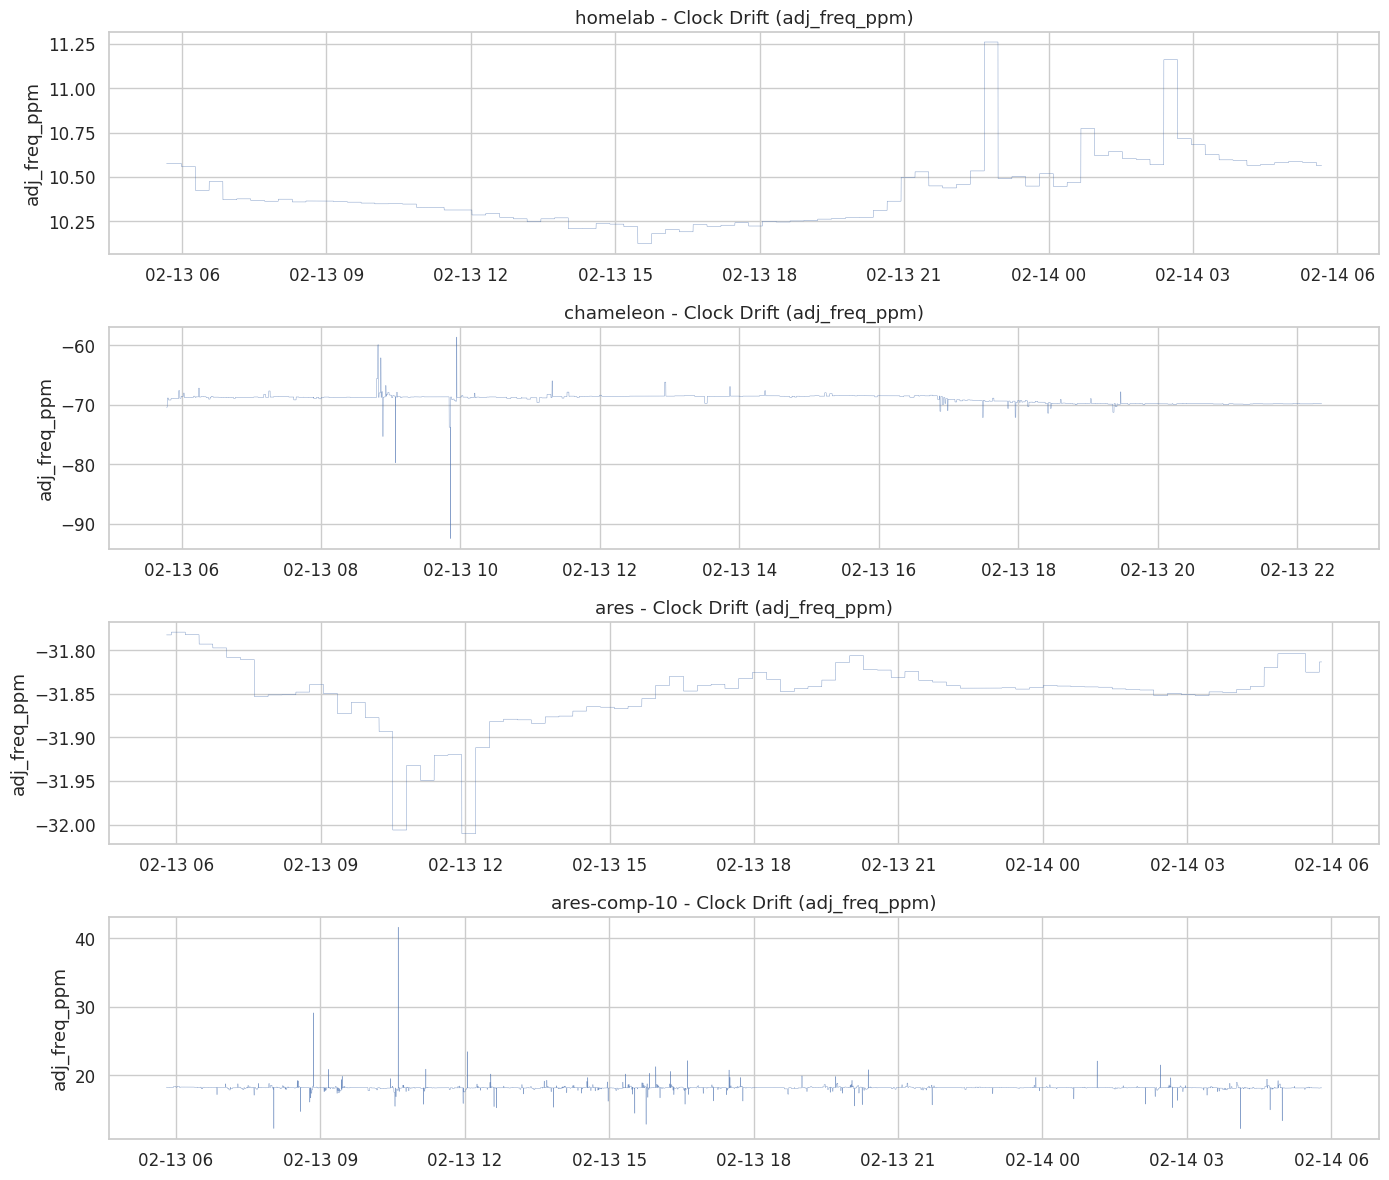

Saved: /content/sensor-collector/tick2/notebooks/output/01/target_timeseries.png


In [4]:
fig, axes = plt.subplots(len(datasets), 1, figsize=(14, 3 * len(datasets)), sharex=False)
if len(datasets) == 1:
    axes = [axes]

for ax, (name, (df, _)) in zip(axes, datasets.items()):
    ax.plot(df.index, df[TARGET_COL], linewidth=0.3, alpha=0.8)
    ax.set_ylabel("adj_freq_ppm")
    ax.set_title(f"{name} - Clock Drift (adj_freq_ppm)")

plt.tight_layout()
fig.savefig(output_dir / "target_timeseries.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {output_dir / 'target_timeseries.png'}")

## 3. Target Statistics

In [5]:
stats = []
for name, (df, _) in datasets.items():
    target = df[TARGET_COL]
    stats.append({
        "Machine": name,
        "Mean (ppm)": f"{target.mean():.4f}",
        "Std (ppm)": f"{target.std():.4f}",
        "Min": f"{target.min():.4f}",
        "Max": f"{target.max():.4f}",
        "Range": f"{target.max() - target.min():.4f}",
        "Rows": len(df),
        "Duration (h)": f"{len(df) / 3600:.1f}",
    })

stats_df = pd.DataFrame(stats)
stats_df.to_csv(output_dir / "target_statistics.csv", index=False)
print(f"Saved: {output_dir / 'target_statistics.csv'}")
stats_df

Saved: /content/sensor-collector/tick2/notebooks/output/01/target_statistics.csv


,Machine,Mean (ppm),Std (ppm),Min,Max,Range,Rows,Duration (h)
0,homelab,10.4124,0.1938,10.1252,11.2614,1.1362,86320,24.0
1,chameleon,-68.9685,0.7920,-92.4749,-58.6038,33.8711,59633,16.6
2,ares,-31.8510,0.0389,-32.0105,-31.7793,0.2312,86398,24.0
3,ares-comp-10,18.1961,0.3256,12.2184,41.6139,29.3955,86398,24.0


## 4. Sensor Categories by Machine

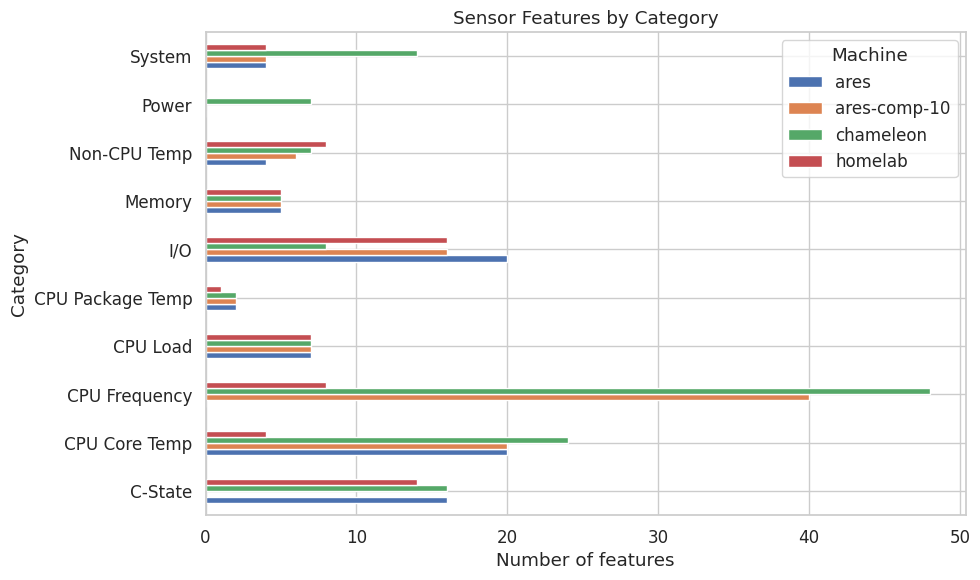

Saved: sensor_categories.png, category_counts.csv


In [6]:
# Count features per category per machine
cat_counts = []
for name, (df, cats) in datasets.items():
    for cat in sorted(set(cats.values())):
        n = sum(1 for c, ct in cats.items() if ct == cat)
        cat_counts.append({"Machine": name, "Category": cat, "Features": n})

cat_df = pd.DataFrame(cat_counts)
cat_df.to_csv(output_dir / "category_counts.csv", index=False)
pivot = cat_df.pivot(index="Category", columns="Machine", values="Features").fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(10, 6))
pivot.plot(kind="barh", ax=ax)
ax.set_xlabel("Number of features")
ax.set_title("Sensor Features by Category")
plt.tight_layout()
fig.savefig(output_dir / "sensor_categories.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: sensor_categories.png, category_counts.csv")

## 5. Autocorrelation of Target

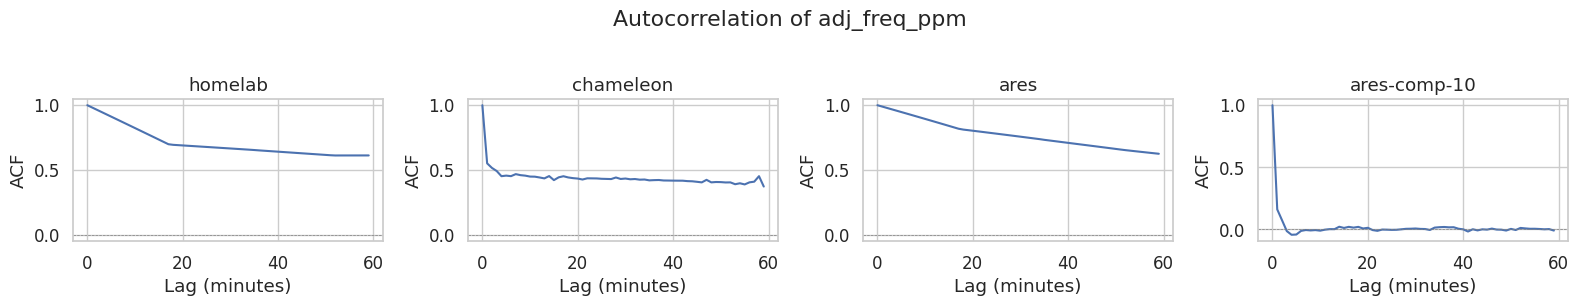

Saved: autocorrelation.png


In [7]:
fig, axes = plt.subplots(1, len(datasets), figsize=(4 * len(datasets), 3))
if len(datasets) == 1:
    axes = [axes]

for ax, (name, (df, _)) in zip(axes, datasets.items()):
    target = df[TARGET_COL].values
    max_lag = min(3600, len(target) // 2)  # up to 1 hour
    lags = np.arange(0, max_lag, 60)  # every minute
    acf = [np.corrcoef(target[:-lag] if lag > 0 else target, target[lag:] if lag > 0 else target)[0, 1] for lag in lags]
    ax.plot(lags / 60, acf)
    ax.set_xlabel("Lag (minutes)")
    ax.set_ylabel("ACF")
    ax.set_title(name)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

plt.suptitle("Autocorrelation of adj_freq_ppm", y=1.02)
plt.tight_layout()
fig.savefig(output_dir / "autocorrelation.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: autocorrelation.png")

## 6. Sample Windows Preview

Preview the (context, horizon) windows that will be used for benchmarking.

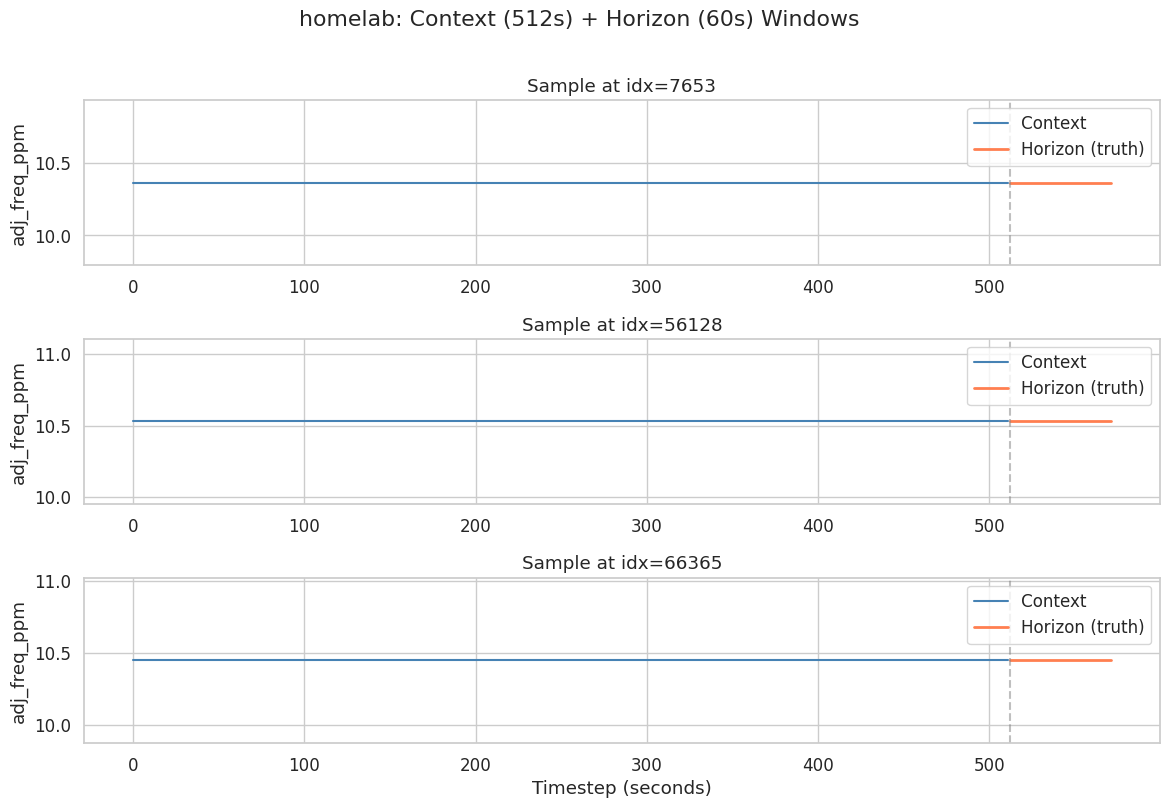

Saved: sample_windows.png


In [8]:
# Show 3 sample windows for the first available machine
first_name = list(datasets.keys())[0]
first_df = datasets[first_name][0]

samples = extract_samples(first_df, TARGET_COL, context_len=512, horizon_len=60, n_samples=3)

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
for ax, s in zip(axes, samples):
    ctx_vals = s.context[TARGET_COL].values
    hz_vals = s.horizon_true.values
    t_ctx = np.arange(len(ctx_vals))
    t_hz = np.arange(len(ctx_vals), len(ctx_vals) + len(hz_vals))

    ax.plot(t_ctx, ctx_vals, label="Context", color="steelblue")
    ax.plot(t_hz, hz_vals, label="Horizon (truth)", color="coral", linewidth=2)
    ax.axvline(x=len(ctx_vals), color="gray", linestyle="--", alpha=0.5)
    ax.set_ylabel("adj_freq_ppm")
    ax.legend(loc="upper right")
    ax.set_title(f"Sample at idx={s.start_idx}")

axes[-1].set_xlabel("Timestep (seconds)")
plt.suptitle(f"{first_name}: Context (512s) + Horizon (60s) Windows", y=1.01)
plt.tight_layout()
fig.savefig(output_dir / "sample_windows.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: sample_windows.png")

## 7. Feature Correlation with Target

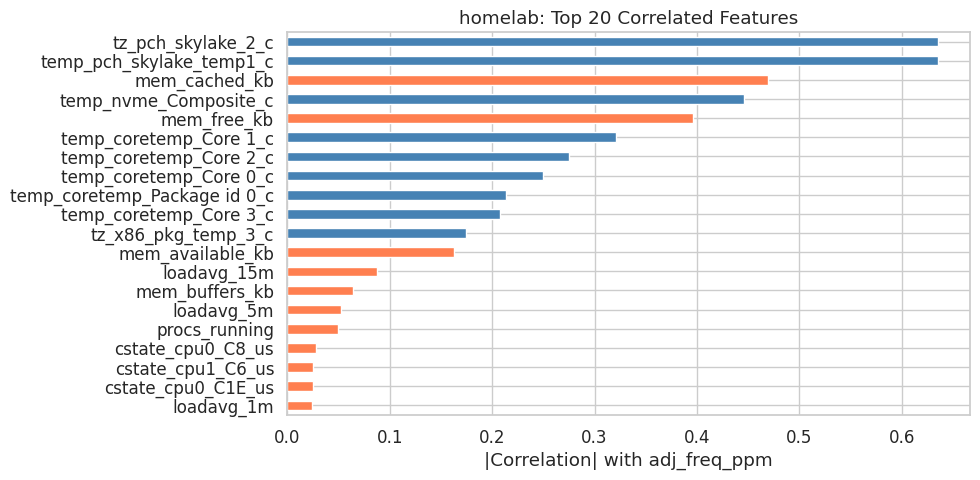

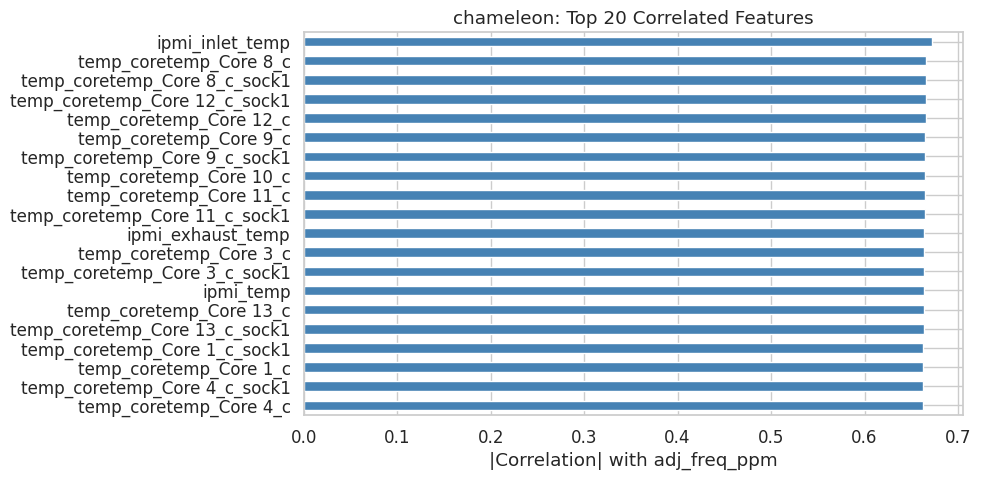

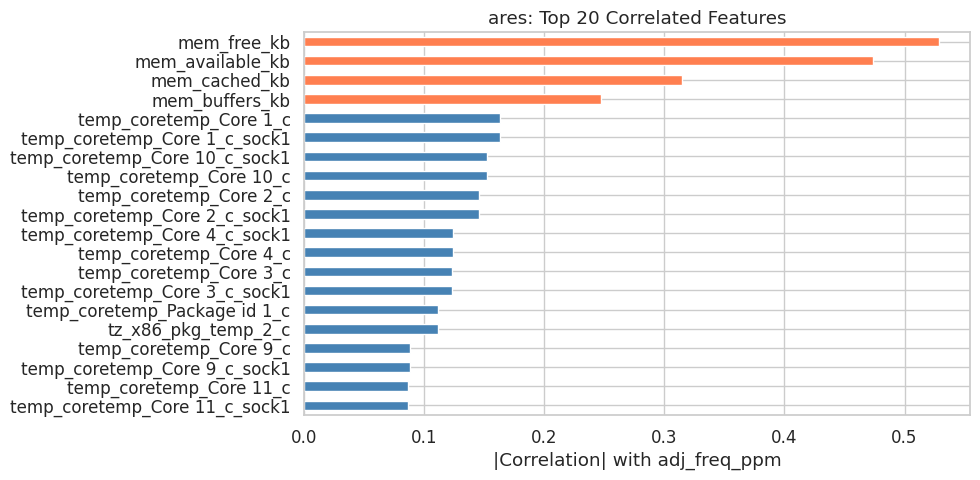

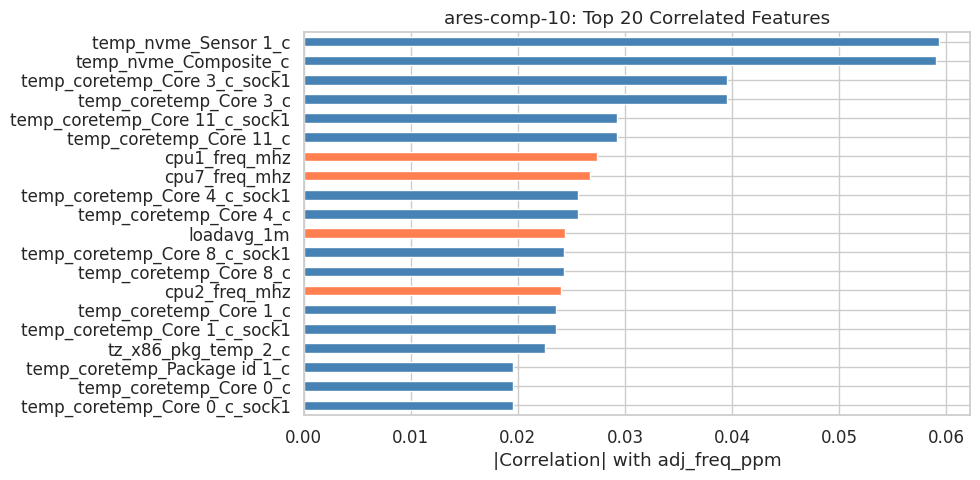

Saved: correlation figures and CSVs for 4 machines


In [9]:
for name, (df, cats) in datasets.items():
    features = get_feature_cols(df)
    if not features:
        continue

    corrs = df[features].corrwith(df[TARGET_COL]).abs().sort_values(ascending=False)
    top_20 = corrs.head(20)

    # Save correlation data
    corrs.to_csv(output_dir / f"correlations_{name}.csv", header=["abs_correlation"])

    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ["steelblue" if cats.get(col, "") in ["CPU Core Temp", "CPU Package Temp", "Non-CPU Temp"] else "coral" for col in top_20.index]
    top_20.plot(kind="barh", ax=ax, color=colors)
    ax.set_xlabel("|Correlation| with adj_freq_ppm")
    ax.set_title(f"{name}: Top 20 Correlated Features")
    ax.invert_yaxis()
    plt.tight_layout()
    fig.savefig(output_dir / f"correlations_{name}.png", dpi=150, bbox_inches="tight")
    plt.show()

print(f"Saved: correlation figures and CSVs for {len(datasets)} machines")

## 8. Save & Push Results

Commit all outputs to the repo so they can be accessed from another machine via `git pull`.

In [ ]:
if IN_COLAB:
    os.chdir(REPO_DIR)

    # Stage all notebook outputs
    subprocess.run(["git", "add", "tick2/notebooks/output/01/"], check=True)

    # Check if there's anything to commit
    status = subprocess.run(
        ["git", "status", "--porcelain", "tick2/notebooks/output/01/"],
        capture_output=True, text=True,
    )
    if status.stdout.strip():
        subprocess.run(
            ["git", "commit", "-m", "results: notebook 01 data exploration outputs"],
            check=True,
        )
        if GITHUB_TOKEN:
            subprocess.run(["git", "push"], check=True)
            print("Pushed notebook 01 outputs to GitHub.")
        else:
            print("Committed locally but GITHUB_TOKEN not set — skipping push.")
            print("Set the secret in Colab sidebar > Secrets > GITHUB_TOKEN")
    else:
        print("No new outputs to commit.")
else:
    print(f"Local run. Outputs saved to: {output_dir}")
    print("Run 'git add tick2/notebooks/output/01/ && git commit && git push' to share.")